In [1]:
import tensorflow as tf
import numpy as np

#### CIFAR10 Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

NameError: name 'tf' is not defined

In [ ]:
def preprocess(images):
  images = images.astype("float32")
  output_images = tf.keras.applications.xception.preprocess_input(images) # -1 to 1

  return output_images

In [ ]:
X_train = preprocess(x_train)
X_test = preprocess(x_test)

In [ ]:
# Transfer Learning

inputs = tf.keras.layers.Input(shape=(32, 32, 3), name="input_layer")
upsample1 = tf.keras.layers.UpSampling2D(size=(7, 7), name="upsample_by_seven")(inputs) # upsample by the factor of 7*7 |

# Xception class
# Get weights of imagenet, not include the top layer for other layers to be add (top layer was a softmax)
# Unlike other transfer learning methds, weights can be updated and not freezed
feature_extractor = tf.keras.applications.Xception(input_shape=(224, 224, 3), include_top=False, weights="imagenet")(upsample1)

# input = (2048, 7, 7) turns into (2048, 1, 1) to avoid lack of translational variancy
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(feature_extractor)

x_flatten = tf.keras.layers.Flatten(name="flatten1")(x)

dense1 = tf.keras.layers.Dense(1024, activation="relu", name="dense1", kernel_initializer="he_normal")(x_flatten)
dense2 = tf.keras.layers.Dense(512, activation="relu", name="dense2", kernel_initializer="he_normal")(dense1)
output = tf.keras.layers.Dense(10, activation="softmax", name="output")(dense2)

model = tf.keras.Model(inputs, outputs=output, name="model")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ upsample_by_seven               │ (None, 224, 224, 3)    │             0 │
│ (UpSampling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten1 (Flatten)              │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,489,586 (89.61 MB)

 Trainable params: 23,435,058 (89.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
# history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
type(model.layers) # A list

list

In [ ]:
print(model.layers[2])

<Functional name=xception, built=True>


In [ ]:
print(model.layers[2].layers) # Since it's a Functional layer, it has several sublayers listable like this

[<InputLayer name=input_layer, built=True>, <Conv2D name=block1_conv1, built=True>, <BatchNormalization name=block1_conv1_bn, built=True>, <Activation name=block1_conv1_act, built=True>, <Conv2D name=block1_conv2, built=True>, <BatchNormalization name=block1_conv2_bn, built=True>, <Activation name=block1_conv2_act, built=True>, <SeparableConv2D name=block2_sepconv1, built=True>, <BatchNormalization name=block2_sepconv1_bn, built=True>, <Activation name=block2_sepconv2_act, built=True>, <SeparableConv2D name=block2_sepconv2, built=True>, <BatchNormalization name=block2_sepconv2_bn, built=True>, <Conv2D name=conv2d, built=True>, <MaxPooling2D name=block2_pool, built=True>, <BatchNormalization name=batch_normalization, built=True>, <Add name=add, built=True>, <Activation name=block3_sepconv1_act, built=True>, <SeparableConv2D name=block3_sepconv1, built=True>, <BatchNormalization name=block3_sepconv1_bn, built=True>, <Activation name=block3_sepconv2_act, built=True>, <SeparableConv2D name

In [ ]:
for layer in model.layers[2].layers[:100]:
  layer.trainable = False # Freeze the weights

In [ ]:
# history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate

def conv2d_layers(input_layer, num_filters):
  conv1 = Conv2D(num_filters, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(input_layer)
  drop = Dropout(0.1)(conv1)
  x = Conv2D(num_filters, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(drop)

  return x

def encoder(input_layer, num_filters):
  conv1 = conv2d_layers(input_layer, num_filters) # Will be used for making residual connenctions
  x = MaxPooling2D((2, 2))(conv1)

  return conv1, x

def decoder(input_layer, src_encode_target, num_filters):
  deconv1 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_layer)
  bridge = concatenate([deconv1, src_encode_target])
  x = conv2d_layers(bridge, num_filters)

  return x

In [ ]:
# Prepare
input = Input(shape=(128, 128, 3))

# Encoder
encoder1, pool1 =  encoder(input, 16)
encoder2, pool2 = encoder(pool1, 32)
encoder3, pool3 = encoder(pool2, 64)
encoder4, pool4 = encoder(pool3, 128)

# Residual Connection
bridge = conv2d_layers(pool4, 256) # Last residual conn, bridge between encoder and decoder

# Decoder
decoder1 = decoder(bridge, encoder4, 128)
decoder2 = decoder(decoder1, encoder3, 64)
decoder3 = decoder(decoder2, encoder2, 32)
decoder4 = decoder(decoder3, encoder1, 16)

outputs = Conv2D(3 , (1, 1), activation="softmax")(decoder4)

In [ ]:
model = Model(input, outputs)

model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


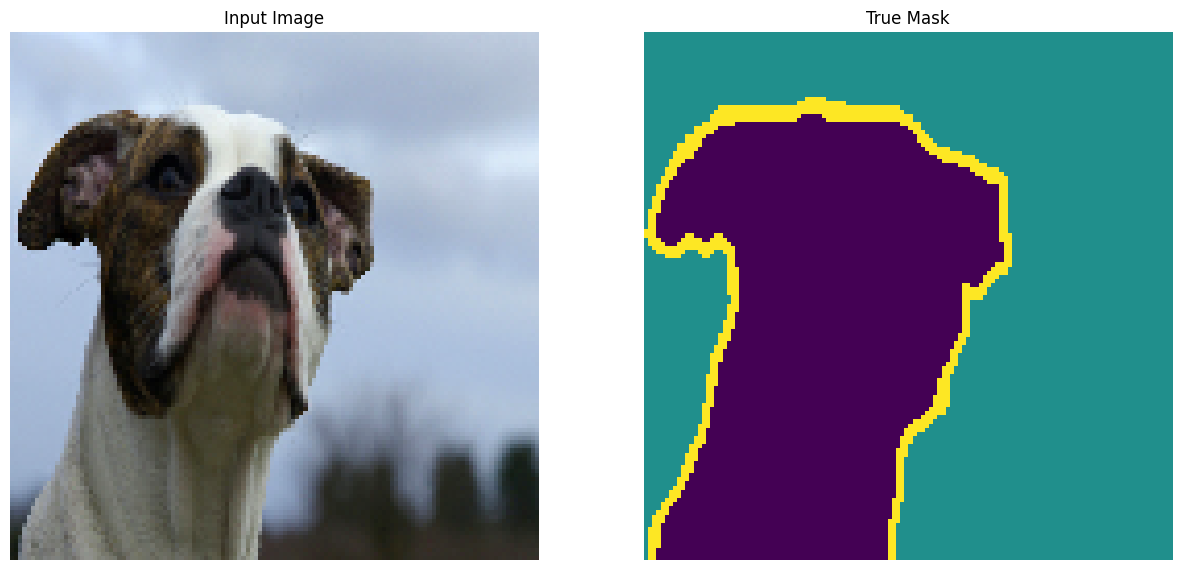

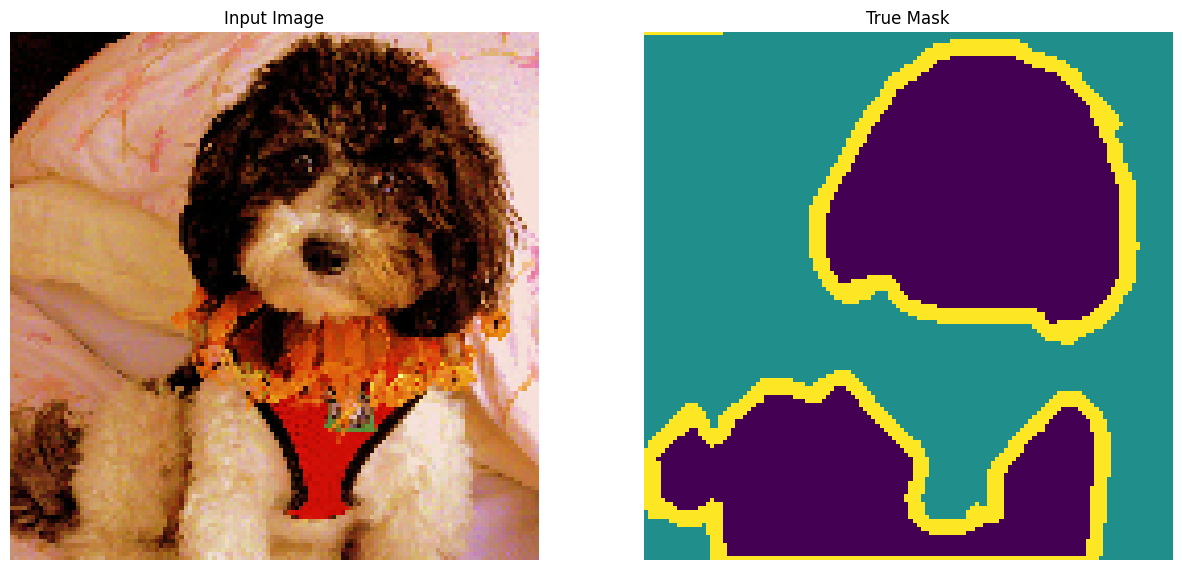

In [ ]:


class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


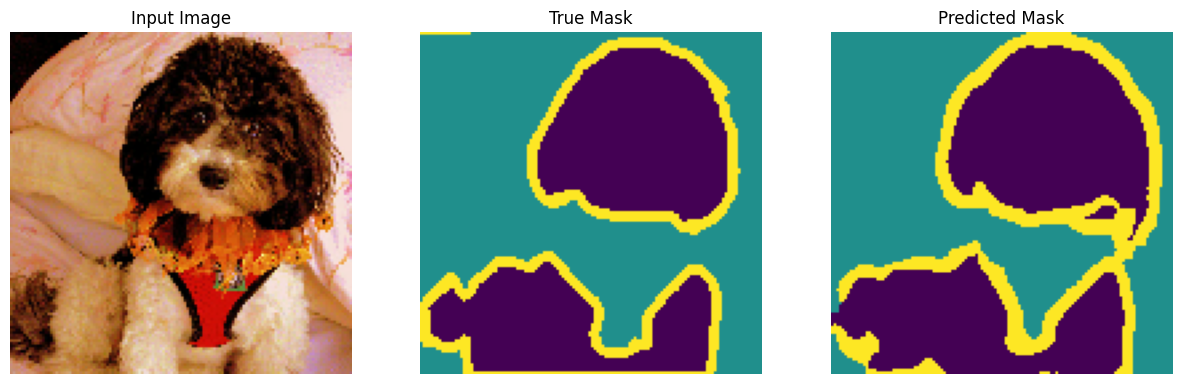


Sample Prediction after epoch 50

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - accuracy: 0.9275 - loss: 0.1775 - val_accuracy: 0.8794 - val_loss: 0.4137


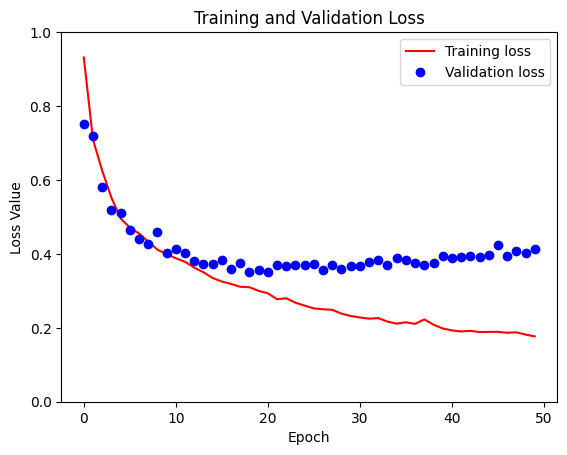

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


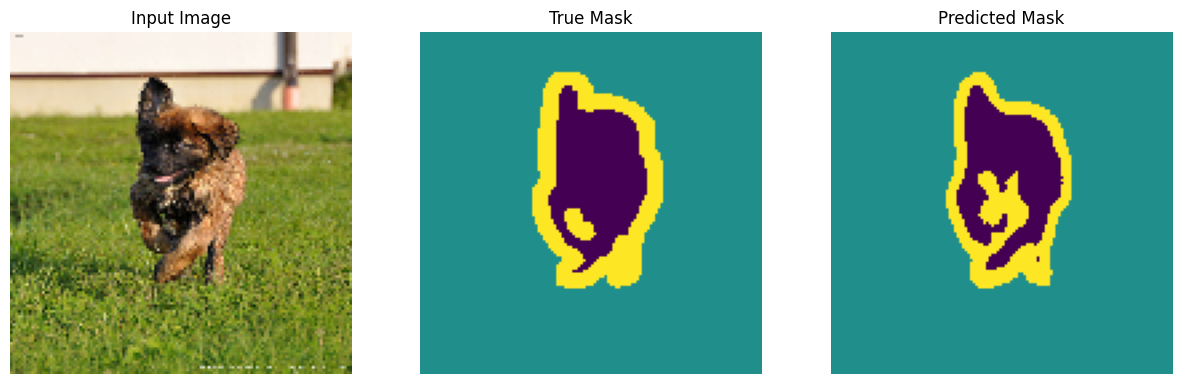

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


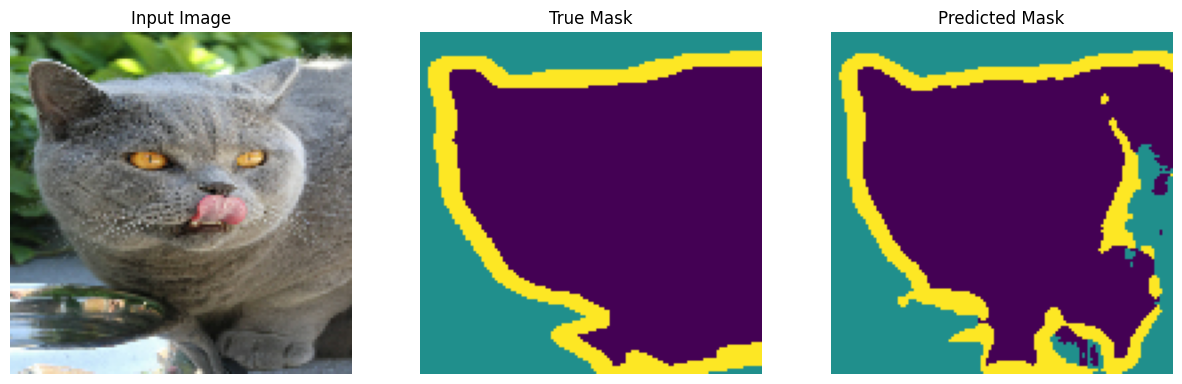

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


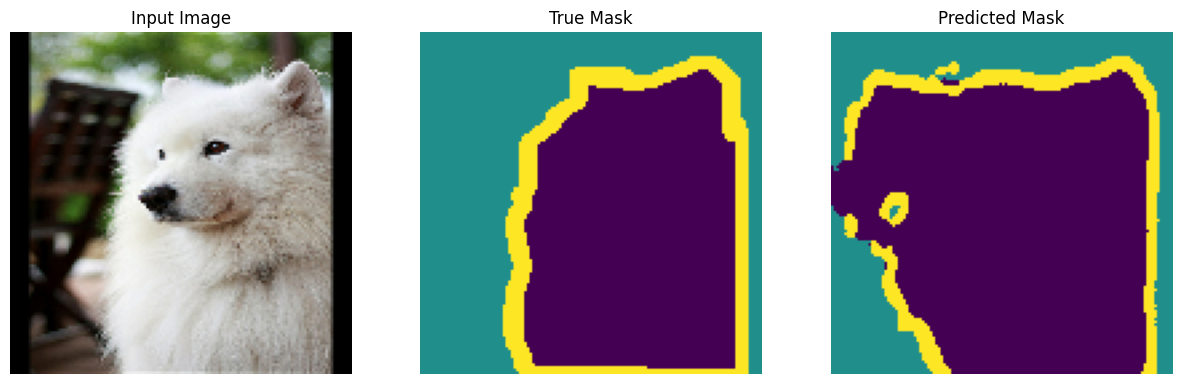

In [ ]:


tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)


def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()


from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print (f'\nSample Prediction after epoch {epoch+1}\n')


EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])


loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


show_predictions(test_batches, 3)

#### Intersection Over Union: A similarity measure used for finding the accuracy of an object detection algorithm by comparing the predicted bounding box with the label bounding box. (Intersection area / union of two bounding boxes)

In [ ]:
# args are all the pred and label boxes and not just single boxes
def intersection_over_union(boxes_pred, boxes_labels):
  box_pred_x1 = boxes_pred[..., 0:1] # [..., i:j]: get rid of other dims and only get elements i to j from every row of the matrix and return a vector
  box_pred_y1 = boxes_pred[..., 1:2]
  box_pred_x2 = boxes_pred[..., 2:3]
  box_pred_y2 = boxes_pred[..., 3:4]

  box_label_x1 = boxes_labels[..., 0:1]
  box_label_y1 = boxes_labels[..., 1:2]
  box_label_x2 = boxes_labels[..., 2:3]
  box_label_y2 = boxes_labels[..., 3:4]

  intersected_x1 = tf.maximum(box_pred_x1, box_label_x1)
  intersected_y1 = tf.maximum(box_pred_y1, box_label_y1)
  intersected_x2 = tf.maximum(box_pred_x2, box_label_x2)
  intersected_y2 = tf.maximum(box_pred_y2, box_label_y2)

  intersection = tf.maximum(intersected_x2 - intersected_x1, 0) * tf.maximum(intersected_y2 - intersected_y1, 0)

  pred_box = (box_pred_x2 - box_pred_x1) * (box_pred_y2 - box_pred_y1)
  label_box = (box_label_x2 - box_label_x1) * (box_label_y2 - box_label_y1)

  union = pred_box + label_box - intersection

  iou = intersection / union

  return iou

## Natural Language Processing

### Tokeniztion

In [ ]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)

train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [ ]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_df_shuffled["text"].to_numpy(), train_df_shuffled["target"].to_numpy(), test_size=0.1)

x_train.shape
X_test.shape

(762,)

In [ ]:
X_train[:10], y_train[:10]

(array(['@camilacabello97 Internally and externally screaming',
        '&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z\n@esquireattire',
        'http://t.co/AY6zzcUpnz Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/sC9dNS41Mc',
        'Video:  Fire burns two apartment buildings and blows up car in Manchester http://t.co/5BGcw3EzB5',
        'A brief violent storm swept through the Chicago area Sunday afternoon leading to one death and an evacuation of Lollapalooza and more',
        "NTSB: Virgin Galactic's SpaceshipTwo crash due to structural failure when braking system unlocked early http://t.co/EYSbLYX6L6 via @KPCC @AP",
        "@ItsQueenBaby I'm at work it's a bunch of ppl and buses because the train derailed",
        "the road to success is paved with pennies that I flattened on the train tracks you're welcome.",
        'PennLive - Two families displaced by Mechanicsburg blaze 

In [ ]:
import tensorflow as tf

# Tokenizing (Preprocessing using this layer)
from tensorflow.keras.layers import TextVectorization

# max_token: only tokenize 20000 most frequent words and assign UNK to the others
# output_sequence_lenght: fix the token length to this number
text_vectorizer = TextVectorization(max_tokens=20000, standardize="lower_and_strip_punctuation",
                                    split="whitespace", output_mode="int",
                                    output_sequence_length=15)
# Fit to the training set (Literally Adapt!)
text_vectorizer.adapt(X_train)

In [ ]:
sample_text = "A terrible car accident happend!"
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   3, 2676,  123,  135,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
words = text_vectorizer.get_vocabulary() # Returns all the words fitted to

print(words[:5]) # Most commen
print(words[-5:]) # Least commen

['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
[np.str_('attackonstiles'), np.str_('attackclose'), np.str_('attached'), np.str_('att'), np.str_('atom')]


### Word Embedding
#### 1. Text -> Tokenizer (vector) -> Embedder (tensor / matrix)

In [ ]:
from tensorflow.keras.layers import Embedding

# input_dim: Vocabulary size same as max_token
# output_dim: embedding vector dims
embedding =  Embedding(input_dim=20000, output_dim=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
tokenized_text = text_vectorizer([sample_text])

embedded_text = embedding(tokenized_text)

# (num_of_tokenized_texts(batch size), tokenized_text_vector_dim, embedding_output_dim)
embedded_text.shape

TensorShape([1, 15, 128])

In [ ]:
import numpy as np

sample_text2 = "I heard a crash accident"

sample2_vectorized = text_vectorizer([sample_text2])

embedd2 = embedding(sample2_vectorized)

cosine_sim = np.dot(embedd2[0][3], embedd2[0][4]) / (np.linalg.norm(embedd2[0][3]) * np.linalg.norm(embedd2[0][4])) # "crash" and "accident"

cosine_sim

np.float32(-0.03725586)

In [ ]:
from tensorflow.keras.layers import *

inputs = Input(shape=(1,), dtype=tf.string) # input shape 1 means input should be only a single string. (no batches included)
x = text_vectorizer(inputs)
x = embedding(x)
x = Dropout(0.5)(x)

x = Conv1D(filters=128, kernel_size=5, strides=1, activation="relu", padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="same")(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)
x = Dense(32, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs, name="nlp_first")

model.compile(optimizer="Adam", loss="BinaryCrossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "nlp_first"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 15, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 64)          │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,705,729 (10.32 MB)

 Trainable params: 2,705,729 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6269 - loss: 0.6412 - val_accuracy: 0.7900 - val_loss: 0.4578
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8680 - loss: 0.3458 - val_accuracy: 0.7927 - val_loss: 0.4550
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9280 - loss: 0.2112 - val_accuracy: 0.7388 - val_loss: 0.6182
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9615 - loss: 0.1140 - val_accuracy: 0.7100 - val_loss: 0.8029
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9794 - loss: 0.0622 - val_accuracy: 0.7415 - val_loss: 1.0121
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9878 - loss: 0.0425 - val_accuracy: 0.7585 - val_loss: 0.9947
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9860 - loss: 0.0338 - val_accuracy: 0.7625 - val_loss: 1.3906
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9880 - loss: 0.0237 - val_accuracy

In [ ]:
model.predict(tf.constant([X_test[0], X_test[1]])) # typecast the simple python strings to tf.string

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[1.        ],
       [0.89741135]], dtype=float32)

In [ ]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

base_model = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
base_model.trainable = False # Freeze

input = tf.keras.layers.Input(shape=(224, 224, 3))
middleware = base_model(input)
x = tf.keras.layers.GlobalAveragePooling2D()(middleware)
output = tf.keras.layers.Dense(10, activation="softmax", kernel_initializer="he_normal")(x)

model = tf.keras.Model(input, output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["accuracy"])

In [ ]:
(cifar_train_data, cifar_train_label), (cifar_test_data, cifar_test_label) = tf.keras.datasets.cifar10.load_data()

def preprocess(images):
  resized_images = tf.image.resize(images, [224, 224], method="bilinear")

  normalized_images = tf.keras.applications.resnet50.preprocess_input(resized_images)

  return normalized_images

import matplotlib.pyplot as plt

preprocessed_train_set = preprocess(cifar_train_data[:1000])
preprocessed_test_set = preprocess(cifar_test_data[:1000])

preprocessed_train_set.shape

TensorShape([1000, 224, 224, 3])

In [ ]:
train_labels = cifar_train_label[:1000]
test_labels = cifar_test_label[:1000]

In [ ]:
history = model.fit(preprocessed_train_set, train_labels, epochs=10, batch_size=10, validation_data=(preprocessed_test_set, test_labels))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.4422 - loss: 1.6871 - val_accuracy: 0.7740 - val_loss: 0.6685
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8837 - loss: 0.3968 - val_accuracy: 0.7930 - val_loss: 0.5786
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9371 - loss: 0.2364 - val_accuracy: 0.8220 - val_loss: 0.5161
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9711 - loss: 0.1515 - val_accuracy: 0.8260 - val_loss: 0.4916
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9932 - loss: 0.0896 - val_accuracy: 0.8340 - val_loss: 0.4697
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9989 - loss: 0.0663 - val_accuracy: 0.8420 - val_loss: 0.4594
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9999 - loss: 0.0460 - val_accuracy: 0.8380 - val_loss: 0.4796
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 1.0000 - loss: 0.0452 - val_

In [ ]:
history.history

{'accuracy': [0.6200000047683716,
  0.8949999809265137,
  0.9459999799728394,
  0.9679999947547913,
  0.9860000014305115,
  0.996999979019165,
  0.9980000257492065,
  1.0,
  1.0,
  1.0],
 'loss': [1.1279774904251099,
  0.37181350588798523,
  0.2197718322277069,
  0.15702751278877258,
  0.09338946640491486,
  0.06380046159029007,
  0.05046585947275162,
  0.03957359865307808,
  0.030350999906659126,
  0.025066934525966644],
 'val_accuracy': [0.7739999890327454,
  0.7929999828338623,
  0.8220000267028809,
  0.8259999752044678,
  0.8339999914169312,
  0.8420000076293945,
  0.8379999995231628,
  0.843999981880188,
  0.8489999771118164,
  0.847000002861023],
 'val_loss': [0.6684526801109314,
  0.5785616636276245,
  0.5161358118057251,
  0.491569459438324,
  0.46967899799346924,
  0.4594075679779053,
  0.4796260595321655,
  0.4565616250038147,
  0.45625069737434387,
  0.4683326780796051]}

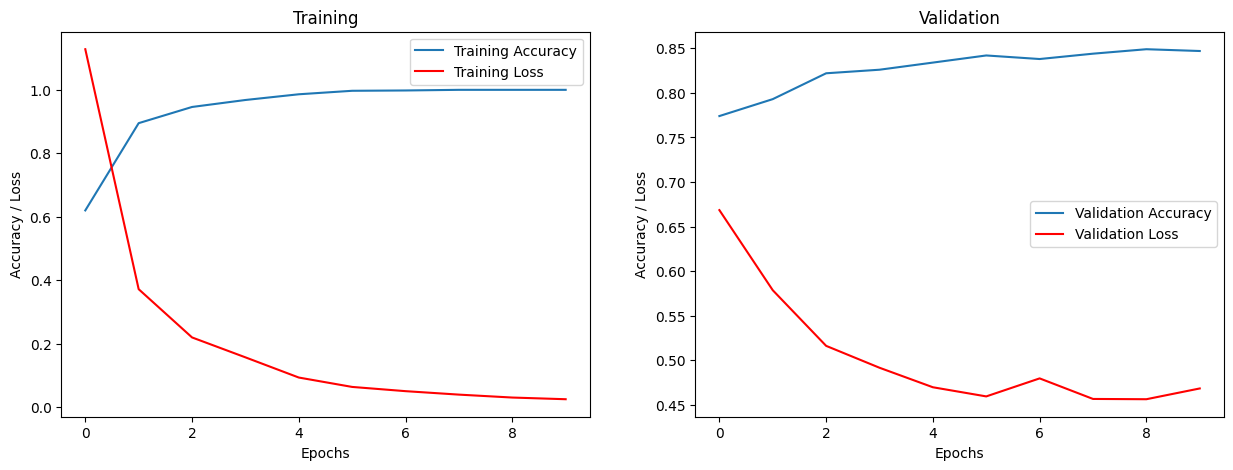

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['accuracy'], label="Training Accuracy")
plt.plot(history.epoch, history.history["loss"], label="Training Loss", color="r")
plt.title("Training")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")

plt.subplot(1, 2 ,2)
plt.plot(history.epoch, history.history['val_accuracy'], label="Validation Accuracy")
plt.plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="r")
plt.title("Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy / Loss")

plt.show()

## Transformers

### Positional Encoding

In [ ]:
import tensorflow as tf
from math import sin, cos

def positional_encoding(dim, position):
  position_encoded = []

  for i in range(dim):
    if i % 2 == 0:
      position_encoded.append(sin(position / 10000 ** ((2 * i) / dim)))
    else :
      position_encoded.append(cos(position / 10000 ** ((2 * i) / dim)))

  return position_encoded

sequence_len = 10
dim = 6
sequence_pos_encode = []

for j in range(sequence_len):
  sequence_pos_encode.append(positional_encoding(dim , j))

sequence_pos_encode

[[0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.8414709848078965,
  0.9989229760406304,
  0.0021544330233656045,
  0.999999995,
  4.641588833596115e-06,
  0.9999999999999768],
 [0.9092974268256817,
  0.9956942241237399,
  0.0043088560467428125,
  0.9999999800000001,
  9.28317766709223e-06,
  0.9999999999999072],
 [0.1411200080598672,
  0.990320699135675,
  0.006463259070189646,
  0.9999999550000004,
  1.3924766500388347e-05,
  0.9999999999997912],
 [-0.7568024953079282,
  0.9828139759067526,
  0.008617632093856952,
  0.999999920000001,
  1.8566355333384463e-05,
  0.9999999999996286],
 [-0.9589242746631385,
  0.9731902242785205,
  0.010771965118034833,
  0.9999998750000026,
  2.320794416598058e-05,
  0.9999999999994198],
 [-0.27941549819892586,
  0.9614701742731442,
  0.012926248143199044,
  0.9999998200000054,
  2.7849532998076695e-05,
  0.9999999999991646],
 [0.6569865987187891,
  0.9476790714399449,
  0.015080471170057421,
  0.99999975500001,
  3.249112182957281e-05,
  0.9999999999988628],
 [0.

In [ ]:
import tensorflow_hub as hub # Has all the models
import tensorflow_text as text

In [ ]:
preprocess_api = "https://www.kaggle.com/models/tensorflow/bert/Tensorflow2/en-uncased-preprocess/3"
encoder_api = "https://www.kaggle.com/models/tensorflow/bert/Tensorflow2/bert-en-uncased-1-12-h-768-a-12/2"

In [ ]:
# How to call from tensorflow hub
preprocessor = hub.KerasLayer(preprocess_api)

preprocessor

In [ ]:
text_data = ["I love Irvine. It is a beautiful city."]
text_preprocessed = preprocessor(text_data)

# dict_keys(['input_type_ids', 'input_mask', 'input_word_ids']) -> [type tokens, one-hot-encodings, tokens] each sentense 128 tokens
# Adds special tokens too
text_preprocessed.keys()

dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])

In [ ]:
text_preprocessed["input_word_ids"]

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[  101,  1045,  2293, 16272,  1012,  2009,  2003,  1037,  3376,
         2103,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
model = hub.KerasLayer(encoder_api)

model

HTTPError: HTTP Error 404: Not Found

In [ ]:
!pip3 install transformers

In [ ]:
from transformers import pipeline # transformers from hugging face

In [ ]:
classfier_model = pipeline(task="sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english") # returns the model to use. Trained of IMDB reviews

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
classfier_model("I loved the movie Back to the Future")

[{'label': 'POSITIVE', 'score': 0.9998339414596558}]

### Bert Base Unmasking

In [ ]:
bert_unmasker = pipeline(task="fill-mask", model="bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
bert_unmasker("Hello I am a [MASK] model")

[{'score': 0.11955532431602478,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': 'hello i am a fashion model'},
 {'score': 0.03929614648222923,
  'token': 2535,
  'token_str': 'role',
  'sequence': 'hello i am a role model'},
 {'score': 0.036753758788108826,
  'token': 2944,
  'token_str': 'model',
  'sequence': 'hello i am a model model'},
 {'score': 0.03636552765965462,
  'token': 2047,
  'token_str': 'new',
  'sequence': 'hello i am a new model'},
 {'score': 0.027765559032559395,
  'token': 3287,
  'token_str': 'male',
  'sequence': 'hello i am a male model'}]

In [2]:
!pip install --upgrade transformers tensorflow_hub safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 125.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [3]:
from transformers import BertTokenizer, TFBertModel

text = "Feel free to encode me"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertModel.from_pretrained("bert-base-uncased")

encoded_input = tokenizer(text, return_tensor="tf")
embedding = model(encoded_input)

embedding

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


TypeError: 'builtins.safe_open' object is not iterable

In [ ]:
summarization = pipeline(task="summarization", model="facebook/bart-large-cnn")

Text = """Reviewers say 'The Walking Dead' is lauded for gripping storytelling, deep character arcs, and moral exploration in a post-apocalyptic setting. Themes of resilience and survival are prominent. Andrew Lincoln and Norman Reedus deliver standout performances. Criticisms include pacing issues, inconsistent development, and repetitive plots, especially in later seasons. Decline in quality, filler episodes, and weak new characters are noted. Despite flaws, the series is praised for atmospheric world-building, realistic zombie effects, and emotional depth."""

summarization(Text, max_length=100, min_length=20, do_sample=False)

Device set to use cuda:0


[{'summary_text': "Reviewers say 'The Walking Dead' is lauded for gripping storytelling, deep character arcs, and moral exploration. Criticisms include pacing issues, inconsistent development, and repetitive plots, especially in later seasons."}]

### Fine-tuning BERT for Sentiment Analysis

In [4]:
from datasets import load_dataset

imdb_set = load_dataset("imdb")

imdb_set

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
from pprint import pprint

pprint(imdb_set["train"][10])

{'label': 0,
 'text': 'It was great to see some of my favorite stars of 30 years ago '
         'including John Ritter, Ben Gazarra and Audrey Hepburn. They looked '
         'quite wonderful. But that was it. They were not given any characters '
         'or good lines to work with. I neither understood or cared what the '
         'characters were doing.<br /><br />Some of the smaller female roles '
         'were fine, Patty Henson and Colleen Camp were quite competent and '
         'confident in their small sidekick parts. They showed some talent and '
         "it is sad they didn't go on to star in more and better films. Sadly, "
         "I didn't think Dorothy Stratten got a chance to act in this her only "
         'important film role.<br /><br />The film appears to have some fans, '
         'and I was very open-minded when I started watching it. I am a big '
         'Peter Bogdanovich fan and I enjoyed his last movie, "Cat\'s Meow" '
         'and all his early ones from 

In [6]:
# Each LLM has its own tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [7]:
def preprocess(reviews):
  return tokenizer(text=reviews["text"], truncation=True)

tokenized_imdb_set = imdb_set.map(preprocess, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [12]:
!pip3 install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [13]:
import evaluate

accucary = evaluate.load("accuracy")

In [14]:
import numpy as np

def compute_metrics(eval_preds: tuple):
  preds, labels = eval_preds

  preds = np.argmax(preds, axis=1)
  return accuracy.compute(preds, references=labels)

In [15]:
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative": 0, "Positive": 1}

In [16]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
subset_size = 1024

steps_per_epoch = subset_size // batch_size

total_train_steps = int(steps_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=2, num_train_steps=total_train_steps)

In [17]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TypeError: 'builtins.safe_open' object is not iterable

In [10]:
shuffled_train_set = tokenized_imdb_set["train"].shuffle(seed=42)
shuffled_validation_set = tokenized_imdb_set["test"].shuffle(seed=42)

In [23]:
# tf_train_set = model.prepare_tf_dataset(
#     shuffled_train_set.select(range(subset_size)),
#     shuffle=False,
#     batch_size=16,
#     collate_fn=data_collator
# )

# tf_validation_set = model.prepare_tf_dataset(
#     shuffled_validation_set.select(range(subset_size)),
#     shuffle=False,
#     batch_size=16,
#     collate_fn=data_collator
# )

# model.compile(optimizer=optmizer, loss=loss)

In [24]:
# from transformers import KerasMetricCallback

# metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

In [25]:
# model.fit()

### ViT for Cifar10 Image Classification

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

train_dataset, test_dataset = load_dataset("cifar10", split=["train[:5000]", "test[:2000]"]) # train_test_split supported

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
train_dataset

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [4]:
train_dataset.features

{'img': Image(mode=None, decode=True),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}

In [5]:
train_dataset[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

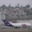

In [6]:
train_dataset[0]["img"]

In [7]:
id2label = {id:label for id, label in enumerate(train_dataset.features["label"].names)}
label2id = {label:id for id, label in enumerate(train_dataset.features["label"].names)}

id2label, label2id

({0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'},
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

In [9]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [12]:
def preprocess_images(data):
  images = data["img"]
  inputs = processor(images, return_tensors="tf")
  data["pixel_values"] = inputs["pixel_values"]
  return data

train_dataset_preprocessed = train_dataset.map(preprocess_images)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [13]:
test_dataset_preprocessed = test_dataset.map(preprocess_images, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### TODO: Complete This Part

In [14]:
from transformers import TFViTForImageClassification as TVIC

# Model is TF recoginzable
model = TVIC.from_pretrained("google/vit-base-patch16-224-in21k", id2label=id2label , label2id=label2id, num_labels=len(id2label))

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


TypeError: 'builtins.safe_open' object is not iterable

### Implementation of VAEs

### Autoencoder for Denoising